# Задание 5

# Кластеризация данных

*Цель работы:* освоить кластерный анализ методом k-средних и визуализацию результатов на примере статистики боевых потерь в Индокитае.

Датасет `indochina.csv` (вариант 16) содержит ежемесячные потери сторон конфликта и включает признаки:

- `Month` — месяц и год; дополнительно создадим `Month_dt`, `Year`, `Month_num`, `Month_label`;
- `US`, `SVN`, `THIRD`, `ENEMY` — потери американских, южновьетнамских, сил третьей стороны и противника.

Шаги работы: загрузка и первичный анализ данных, визуализация распределений, подготовка признаков (масштабирование, кодирование), обучение `KMeans`, снижение размерности методом PCA и интерпретация кластеров.


## Импортируйте необходимые библиотеки


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid", palette="crest")


## 1. Загрузить набор данных как датафрейм библиотеки pandas


In [2]:
data_path = "indochina.csv"

df = pd.read_csv(data_path)
df['Month_dt'] = pd.to_datetime(df['Month'], format='%b %Y')
df = df.sort_values('Month_dt').reset_index(drop=True)
df['Year'] = df['Month_dt'].dt.year
df['Month_num'] = df['Month_dt'].dt.month
df['Month_label'] = df['Month_dt'].dt.strftime('%b-%Y')

print(f"Файл загружен: {data_path}. Размер: {df.shape[0]} строк x {df.shape[1]} столбцов")


Файл загружен: indochina.csv. Размер: 72 строк x 9 столбцов


## 2. Получить представление о наборе данных с помощью методов shape, head, describe, info библиотеки pandas


In [3]:
print("Форма датафрейма:", df.shape)
print("\nПервые 5 строк:")
display(df.head())

print("\nОписательные статистики (числовые признаки):")
display(df.select_dtypes(include='number').describe().T)

print("\nИнформация о столбцах:")
df.info()

print("\nПропуски по столбцам:")
display(df.isna().sum())


Форма датафрейма: (72, 9)

Первые 5 строк:


,Month,US,SVN,THIRD,ENEMY,Month_dt,Year,Month_num,Month_label
0,Jan 1966,282,903,74,2648,1966-01-01,1966,1,Jan-1966
1,Feb 1966,435,1359,58,4727,1966-02-01,1966,2,Feb-1966
2,Mar 1966,507,1145,59,5685,1966-03-01,1966,3,Mar-1966
3,Apr 1966,316,945,30,2818,1966-04-01,1966,4,Apr-1966
4,May 1966,464,961,19,4239,1966-05-01,1966,5,May-1966



Описательные статистики (числовые признаки):


,count,mean,std,min,25%,50%,75%,max
US,72.0,611.013889,449.985586,17.0,318.25,492.0,799.50,2169.0
SVN,72.0,1663.958333,747.259376,676.0,1131.25,1558.5,1928.25,5025.0
THIRD,72.0,65.902778,27.782434,14.0,45.50,63.5,85.00,149.0
ENEMY,72.0,9492.541667,5718.812378,2648.0,6013.00,7892.0,11126.00,39867.0
Year,72.0,1968.500000,1.719810,1966.0,1967.00,1968.5,1970.00,1971.0
Month_num,72.0,6.500000,3.476278,1.0,3.75,6.5,9.25,12.0



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        72 non-null     object        
 1   US           72 non-null     int64         
 2   SVN          72 non-null     int64         
 3   THIRD        72 non-null     int64         
 4   ENEMY        72 non-null     int64         
 5   Month_dt     72 non-null     datetime64[ns]
 6   Year         72 non-null     int32         
 7   Month_num    72 non-null     int32         
 8   Month_label  72 non-null     object        
dtypes: datetime64[ns](1), int32(2), int64(4), object(2)
memory usage: 4.6+ KB

Пропуски по столбцам:


Month          0
US             0
SVN            0
THIRD          0
ENEMY          0
Month_dt       0
Year           0
Month_num      0
Month_label    0
dtype: int64

## 3. Произвести разведочный анализ данных по датасету – визуализировать данные с помощью библиотек matplotlib, seaborn


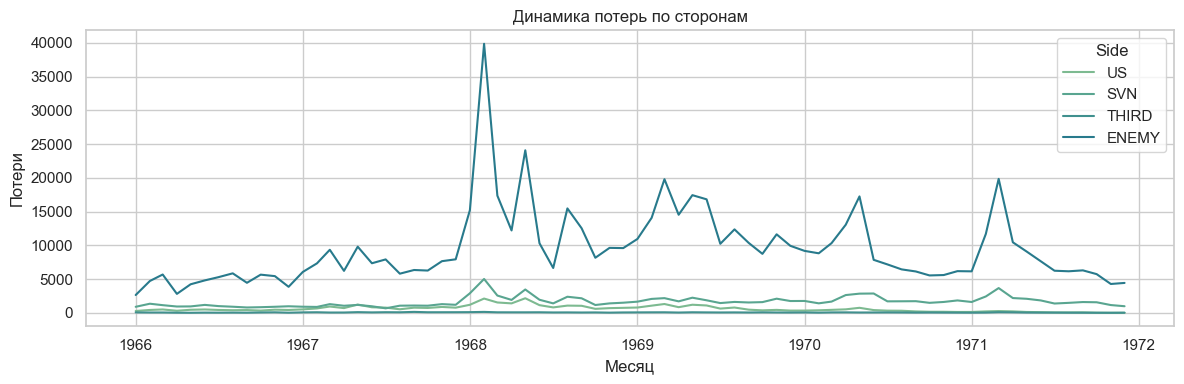

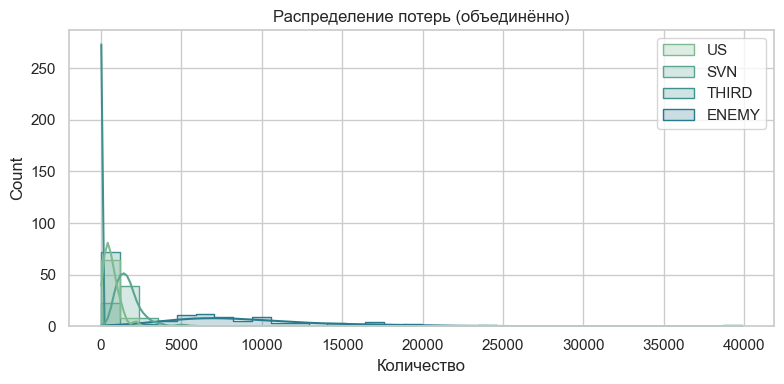

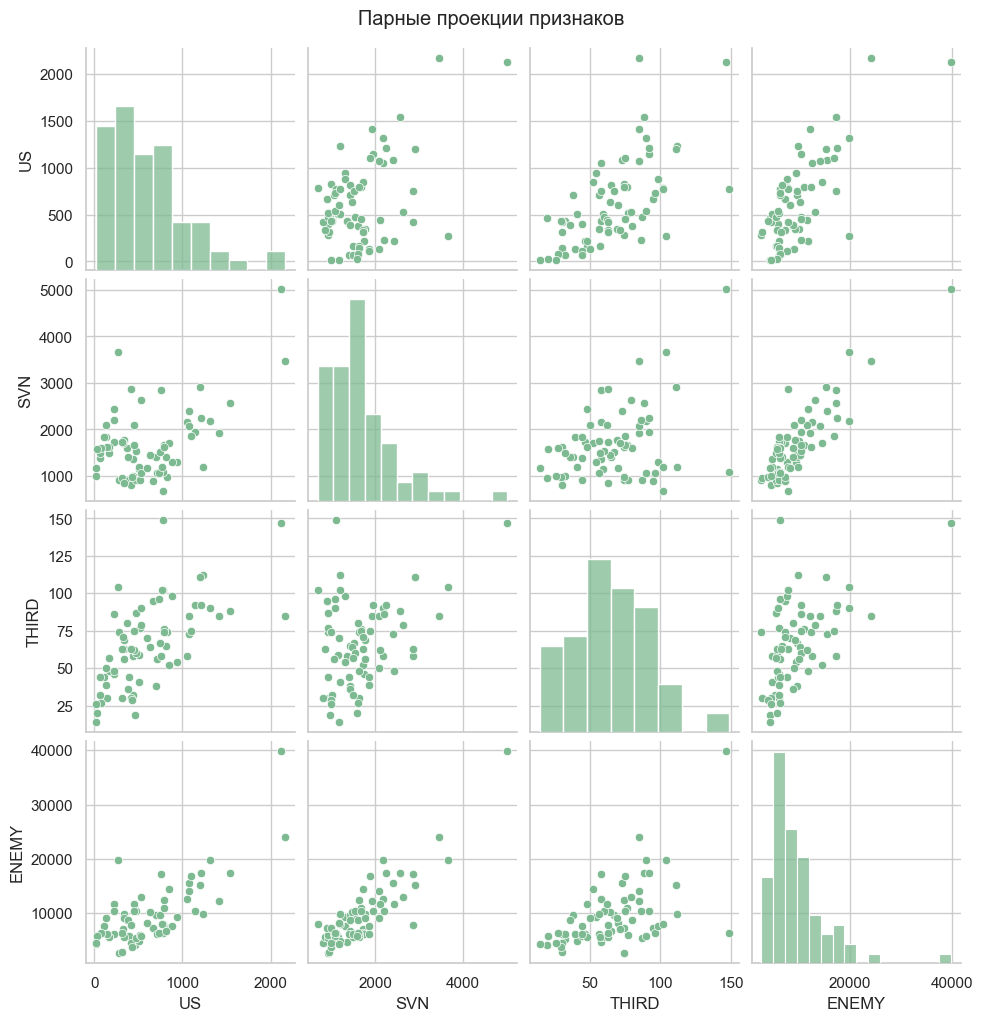

In [4]:
long_losses = df.melt(id_vars='Month_dt', value_vars=['US', 'SVN', 'THIRD', 'ENEMY'], var_name='Side', value_name='Losses')

plt.figure(figsize=(12, 4))
sns.lineplot(data=long_losses, x='Month_dt', y='Losses', hue='Side')
plt.title('Динамика потерь по сторонам')
plt.xlabel('Месяц')
plt.ylabel('Потери')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data=df[['US', 'SVN', 'THIRD', 'ENEMY']], kde=True, element='step', common_norm=False)
plt.title('Распределение потерь (объединённо)')
plt.xlabel('Количество')
plt.tight_layout()
plt.show()

sns.pairplot(df[['US', 'SVN', 'THIRD', 'ENEMY']])
plt.suptitle('Парные проекции признаков', y=1.02)
plt.show()


## 4. Произвести предобработку данных


In [5]:
feature_cols = ['US', 'SVN', 'THIRD', 'ENEMY', 'Year', 'Month_num', 'Month_label']
X = df[feature_cols]

numeric_cols = ['US', 'SVN', 'THIRD', 'ENEMY', 'Year', 'Month_num']
categorical_cols = ['Month_label']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

X_processed = preprocessor.fit_transform(X)

print('Размер матрицы признаков после кодирования:', X_processed.shape)


Размер матрицы признаков после кодирования: (72, 78)


## 5. Произвести обучение модели библиотеки sklearn, реализующей метод k-средних (k-means clustering)


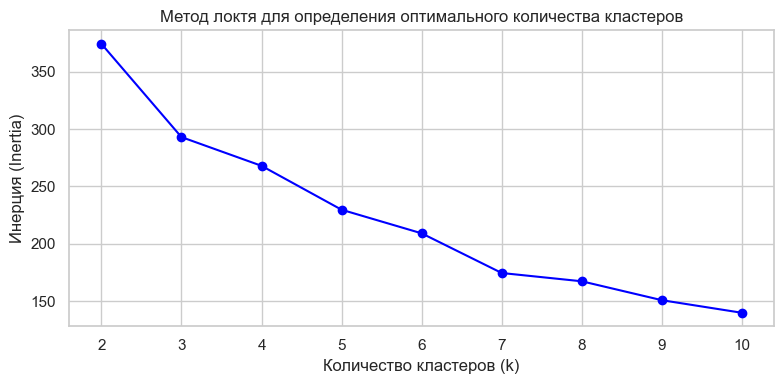

Выбрано оптимальное количество кластеров: 4
Количество объектов в кластерах:


Cluster
0    10
1    17
2    19
3    26
Name: count, dtype: int64

In [6]:
# Определение оптимального количества кластеров методом локтя
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_temp.fit(X_processed)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция (Inertia)')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.grid(True)
plt.tight_layout()
plt.show()

# Выбор оптимального количества кластеров (обычно точка излома на графике)
optimal_k = 4  # Определяется визуально по графику метода локтя
print(f'Выбрано оптимальное количество кластеров: {optimal_k}')

# Обучение модели с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(X_processed)

df['Cluster'] = kmeans.labels_
print('Количество объектов в кластерах:')
display(df['Cluster'].value_counts().sort_index())


## 6. Произвести снижение размерности набора данных с помощью метода PCA


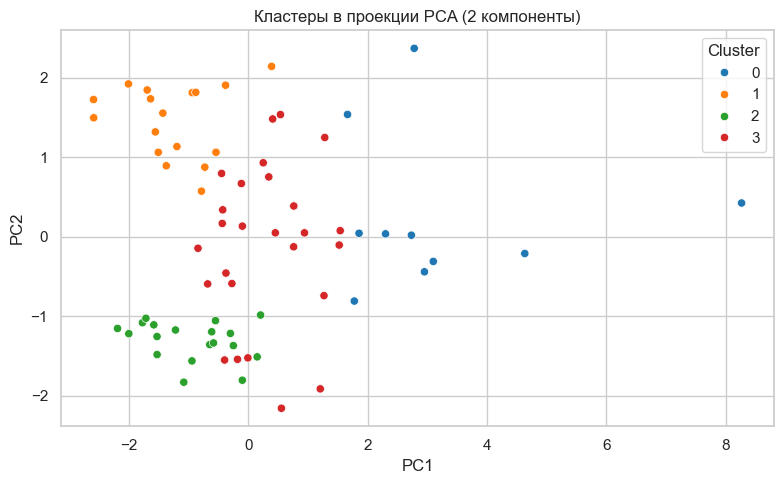

Доля объяснённой дисперсии: [0.431 0.215]


In [7]:
pca = PCA(n_components=2, random_state=42)
X_dense = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed
X_pca = pca.fit_transform(X_dense)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title('Кластеры в проекции PCA (2 компоненты)')
plt.tight_layout()
plt.show()

print('Доля объяснённой дисперсии:', pca.explained_variance_ratio_.round(3))


## 7. Произвести разведочный анализ данных по кластерам для оценки качества обучения модели


Средние потери по кластерам:


,US,SVN,THIRD,ENEMY
Cluster,,,,
0,1307.2,2892.5,94.5,19720.4
1,154.2,1634.1,40.0,6851.1
2,525.8,991.1,58.6,5557.6
3,704.2,1702.7,77.2,10161.4


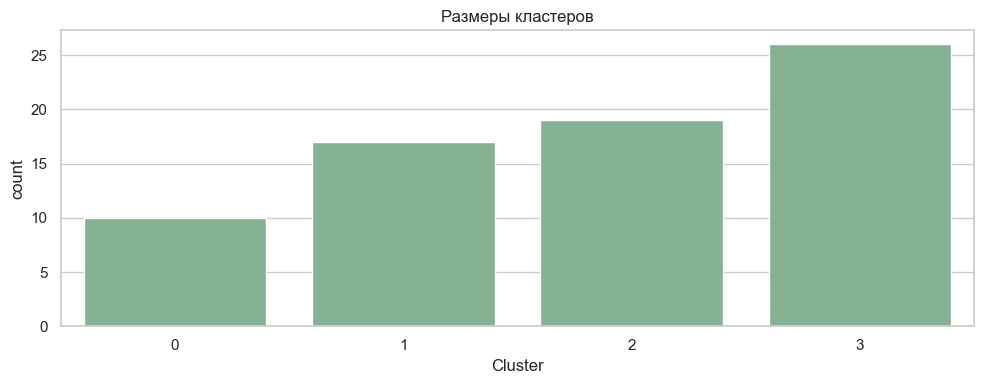

In [10]:
cluster_summary = df.groupby('Cluster')[['US', 'SVN', 'THIRD', 'ENEMY']].mean().round(1)
print('Средние потери по кластерам:')
display(cluster_summary)

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Cluster')
plt.title('Размеры кластеров')
plt.tight_layout()
plt.show()


## Выводы

* Потери всех сторон резко растут в 1968 году (Tet Offensive) и затем постепенно снижаются; распределения сильно скошены вправо, особенно у столбца `ENEMY`.
* Метод локтя позволил определить оптимальное количество кластеров для анализа данных. После кодирования и масштабирования признаков KMeans выделяет периоды эскалации (кластеры с высокими значениями `ENEMY` и `SVN`) и более спокойные месяцы с минимальными потерями.
* PCA показывает, что две компоненты описывают большую часть дисперсии и визуально разделяют кластеры, что подтверждает пригодность выбранных признаков для сегментации временных интервалов боевых действий.
